In [11]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# libraries for partitioning and batching the data
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_17612/1094594094.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


## IRIS

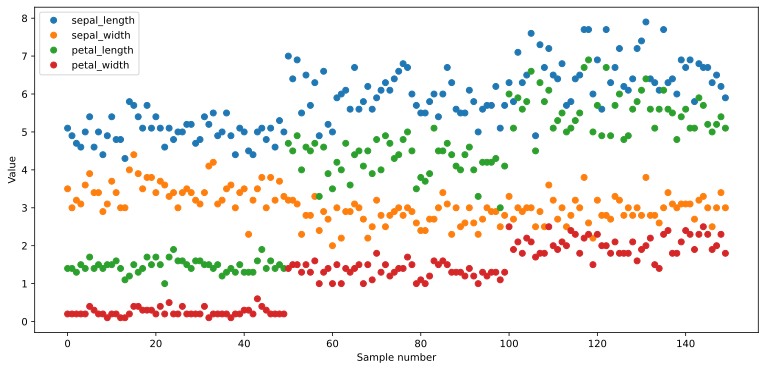

In [12]:
import seaborn as sns
iris = sns.load_dataset('iris')

# Organize the data

# Convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# Transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Plot the data
iris.plot(marker='o', linestyle='none', figsize=(13, 6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

# SEPARATE THE DATA INTO BATCHES

In [13]:
# Separate the data into DataLoaders
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# Then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Convert to dataloaders later ...

# Things related to the model

In [14]:
def create_a_new_model():

    # Model architecture
    ANN_model = nn.Sequential(
        nn.Linear(in_features=4, out_features=64),  # Input layer
        nn.ReLU(),                                  # Activation unit
        nn.Linear(in_features=64, out_features=64), # Hidden unit
        nn.ReLU(),                                  # Activation unit
        nn.Linear(in_features=64, out_features=3)   # Output unit
    )
    # Loss function
    loss_func = nn.CrossEntropyLoss() # For multiple class

    # Optimizer
    optimizer = torch.optim.SGD(params=ANN_model.parameters(), lr=0.001)

    return ANN_model, loss_func, optimizer

## TRAIN THE MODEL

In [15]:
# Global parameter
num_epochs = 500

def train_the_model(ANN_model, loss_func, optimizer):

  # Initialize accuracies as empties
  train_acc = []
  test_acc  = []
  losses = []

  # Loop over epochs
  for epoch_i in range(num_epochs):
    # Activate training mode
    ANN_model.train()

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = ANN_model(X)
      loss  = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())
      batch_loss.append(loss.item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy
    train_acc.append(np.mean(batch_acc))
    losses.append(np.mean(batch_loss))

    # Test accuracy (NOTE: testing in batches!)
    # Extract x,y from test dataloader
    X, y = next(iter(test_loader))
    # Activate testing mode
    ANN_model.eval()
    with torch.no_grad():
      pred_labels = torch.argmax(ANN_model(X), axis=1)
    # Compute accuracy
    test_acc.append(100 * torch.mean((pred_labels == y).float()).item())

  # Function output
  return train_acc, test_acc, losses

# Run the experiment and visualize the results

In [16]:
# Range of batch sizes
batch_sizes = 2 ** np.arange(start=1, stop=7)

# Initialize output results matrices
accuracy_results_train = np.zeros(shape=(num_epochs, len(batch_sizes)))
accuracy_results_test  = np.zeros(shape=(num_epochs, len(batch_sizes)))

# Test data doesn't vary by training batch size
test_loader = DataLoader(dataset=test_dataset, batch_size=test_dataset.tensors[0].shape[0])

# Loop over batch sizes
for batch_size_i in range(len(batch_sizes)):

  # Create dataloader object
  train_loader = DataLoader(dataset=train_dataset, batch_size=int(batch_sizes[batch_size_i]), shuffle=True, drop_last=True)

  # Create and train a model
  ANN_iris, loss_func, optimizer = create_a_new_model()
  train_acc, test_acc, losses = train_the_model(ANN_model=ANN_iris, loss_func=loss_func, optimizer=optimizer)

  # Store results
  accuracy_results_train[:, batch_size_i] = train_acc
  accuracy_results_test[:, batch_size_i]  = test_acc

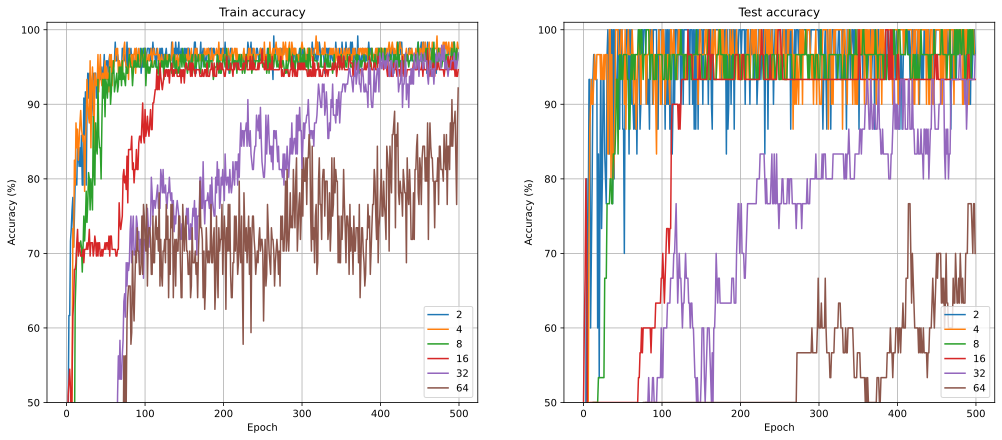

In [17]:
# Plot some results
fig,ax = plt.subplots(1, 2,figsize=(17, 7))

ax[0].plot(accuracy_results_train)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracy_results_test)
ax[1].set_title('Test accuracy')

# Common features
for i in range(2):
  ax[i].legend(batch_sizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50, 101])
  ax[i].grid()

plt.show()

# Additional explorations
1) Why are the minibatch sizes specified in powers of 2? That's partly because DL is developed by math/computer nerds,
   but it's also partly an attempt to optimize computation speed, because computer memory comes in powers of two.
   But 2**N is not a specific requirement. Adjust the code to use batch sizes corresponding to six linearly spaced 
   integers between 2 and 50.

2) Why did I ask you to set the learning rate to .001? Try this experiment again using higher and lower learning rates.
   What do you conclude about batch sizes and learning rate?